In [1]:
import sys 
sys.path.append('../..')
sys.path.append('/opt/anaconda3/lib/python3.7/site-packages')

import subprocess 
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.distributions import Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
import pandas as pd
import numpy as np
import csv
import json
from cox.utils import Parameters
from cox.store import Store

from cox.readers import CollectionReader
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math 

from delphi.stats.linear_regression import TruncatedRegression
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata

TABLE_NAME = 'logs'

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

# commands and arguments
COMMAND = 'Rscript'
PATH2SCRIPT = './truncreg.R'
TMP_FILE = 'tmp.csv'
RESULT_FILE = 'result.csv'

# mean squared error loss
mse_loss = ch.nn.MSELoss()

In [3]:
args = Parameters({
    "bias": True,
    "samples": 1000,
    "c": 0,
    "bs": 10,
    "lr": 1e-1,
    "var_lr": 1e-1,
    "trials": 3,
    "norm": False,
    "workers": 8,
    "steps": 5000,
    "x_lower": -10,
    "x_upper": 10,
    "lower": -1,
    "upper": 1,
    "device": "cuda",
    "num_samples": 100,
    'out_dir': '/Users/patroklos/Regression',
    'eps': 1e-5,
    'var': 5,
    'step_lr': 100, 
    'step_lr_gamma': .9, 
    'tol': 1e-2, 
    'n': 100,
    'attempts': 3,
})

I will start by generating the ground-truth for our expriment.

gt weight:  Parameter containing:
tensor([[0.6548]], requires_grad=True)
gt bias:  Parameter containing:
tensor([[-0.4312]], requires_grad=True)
alpha:  tensor([0.4810])
gt ols coef:  [[0.6922346]]
gt ols intercept:  [-0.3377085]
trunc ols coef:  [[0.22961372]]
trunc ols intercept:  [2.5677595]


Text(0, 0.5, 'y')

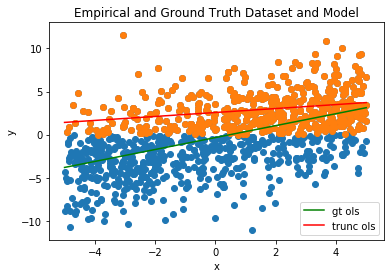

In [3]:
# distribution for generating feature vectors
d, k = 1, 1
w = Uniform(-1, 1)
# m = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
m = Uniform(-5, 5)
phi = oracle.Left(Tensor([0.0]))
# phi = oracle.Identity()

# generate ground truth
gt = ch.nn.Linear(in_features=k, out_features=1)
gt.weight = ch.nn.Parameter(w.sample(ch.Size([k, d])))

# gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None
gt.bias = ch.nn.Parameter(w.sample(ch.Size([1, 1]))) if args.bias else None

print("gt weight: ", gt.weight)
print("gt bias: ", gt.bias)

# create base classifier
with ch.no_grad():
    # generate data
    X = m.sample(ch.Size([args.samples, d])) if isinstance(m, Uniform) else m.sample(ch.Size([args.samples]))
    y = gt(X)

noise_var = Tensor([10.0])[...,None]
# remove synthetic data from the computation graph
with ch.no_grad():
    # add noise to ground-truth pedictions
    noised = y + ch.sqrt(noise_var) * ch.randn(X.size(0), 1)
    # truncate based off of the standardized data
    indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
    y_trunc, x_trunc = noised[indices], X[indices]
    alpha = Tensor([y_trunc.size(0) / args.samples])
    print("alpha: ", alpha)
    
# ground-truth OLS
gt_ols = LinearRegression()
gt_ols.fit(X, noised)
print("gt ols coef: ", gt_ols.coef_)
print("gt ols intercept: ", gt_ols.intercept_)

trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc)
trunc_ols_pred = trunc_ols.predict(x_trunc)
print("trunc ols coef: ", trunc_ols.coef_)
print("trunc ols intercept: ", trunc_ols.intercept_)

# data for plotting regressions
unnorm_data = np.linspace(-5, 5, 100).reshape(100, 1)
norm_data = np.linspace(-1, 1, 100).reshape(100, 1)

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt ols')
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Empirical and Ground Truth Dataset and Model")
ax.set_xlabel("x")
ax.set_ylabel("y")

Now, we want to standardize our truncated dataset, so that our empirical estimates are located on the l2 ball. First we will divide all of our covariate features by $B\sqrt{k}$, so that all of our covariate features $||x_{i}||_{2}^{2} \leq 1$, and reside on the $\ell_{2}$ ball. This way the norm of $w$ will be multiplied by $B\sqrt{k}$.

In [7]:
max_x_trunc_norm = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
print("max truncated x norm", max_x_trunc_norm)

beta = max_x_trunc_norm*math.sqrt(X.size(1))
print("beta: ", beta)

x_trunc_norm = x_trunc / beta
print("x max l2: ", x_trunc_norm.norm(dim=-1).max())

max truncated x norm tensor(4.9966)
beta:  tensor(4.9966)
x max l2:  tensor(1.)


We now observe that the norm of the truncated x covariates is bounded by 1. So, now we will standardze our dependent variable so that it's ground-truth takes the form of the linear regression latent variable model with noise variance of 1. First, let's calculate the predicted values from our naive ols regression on teh truncated data.

First, we will standardize our data for the case where we assume that the empirical noise variance is the underlying noise variance of the ground truth regression.

emp noise var:  tensor([4.6769])
trunc reg noise var:  tensor([1.])


Text(0, 0.5, 'y')

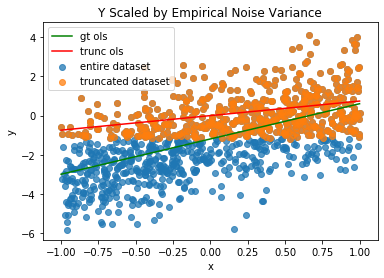

In [8]:
emp_noise_var = (y_trunc - trunc_ols_pred).var(0)
print("emp noise var: ", emp_noise_var)

emp_stand_y_trunc = (y_trunc - trunc_ols.intercept_) / ch.sqrt(emp_noise_var)
trunc_noise_var = (emp_stand_y_trunc - (trunc_ols_pred / ch.sqrt(emp_noise_var))).var(0)
print("trunc reg noise var: ", trunc_noise_var)

new_X, emp_stand_noised = X / beta, (noised - trunc_ols.intercept_) / ch.sqrt(emp_noise_var)

gt_emp_stand = LinearRegression()
gt_emp_stand.fit(new_X, emp_stand_noised)

trunc_emp_stand_ols = LinearRegression()
trunc_emp_stand_ols.fit(x_trunc_norm, emp_stand_y_trunc)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title('Y Scaled by Empirical Noise Variance')
ax.set_xlabel("x")
ax.set_ylabel("y")

First, we will standardize our data for the case where we assume that we know the underlying ground-truth noise variance.

trunc reg noise var:  tensor([0.4677])
reg noise var:  tensor([0.9581])


Text(0, 0.5, 'y')

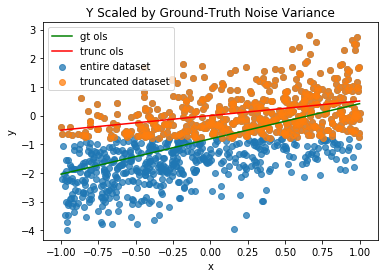

In [9]:
stand_noised, stand_y_trunc = (noised - trunc_ols.intercept_) / ch.sqrt(noise_var), (y_trunc - trunc_ols.intercept_) / ch.sqrt(noise_var)

gt_stand = LinearRegression()
gt_stand.fit(new_X, stand_noised)

trunc_stand_ols = LinearRegression()
trunc_stand_ols.fit(x_trunc_norm, stand_y_trunc)

trunc_noise_var = (stand_y_trunc - trunc_stand_ols.predict(x_trunc_norm)).var(0)
print("trunc reg noise var: ", trunc_noise_var)

reg_noise_var = (stand_noised - gt_stand.predict(new_X)).var(0)
print("reg noise var: ", reg_noise_var)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Y Scaled by Ground-Truth Noise Variance")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Empirical Variance

In [10]:
emp_scale_phi = oracle.Left((phi.left - trunc_ols.intercept_) / ch.sqrt(emp_noise_var))
known_emp_trunc_reg = TruncatedRegression(phi=emp_scale_phi, alpha=alpha, unknown=False, val=100, bs=10, n=100, tol=1e-2, steps=1500)
known_emp_trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)

known_emp_w_unnorm = (known_emp_trunc_reg.weight * ch.sqrt(emp_noise_var)) / beta
known_emp_bias_unnorm = known_emp_trunc_reg.intercept * ch.sqrt(emp_noise_var) + trunc_ols.intercept_

Iteration: 0.0 | Score: 0.14233669638633728
Iteration: 1.0 | Score: 0.0290553979575634
Iteration: 2.0 | Score: 0.009654086083173752


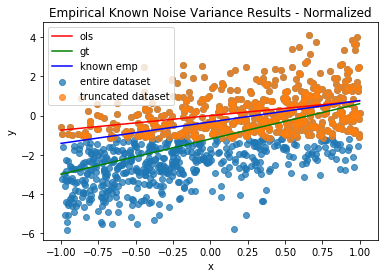

Text(0, 0.5, 'y')

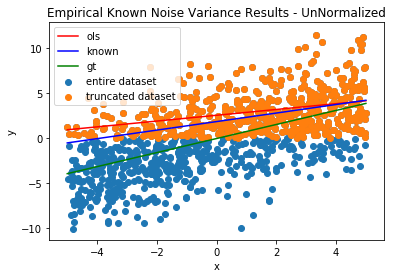

In [11]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_emp_trunc_reg(Tensor(norm_data)).detach().numpy(), label='known emp', color='blue')
plt.legend()
plt.title("Empirical Known Noise Variance Results - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='ols')

plt.plot(unnorm_data, (Tensor(unnorm_data)@known_emp_w_unnorm + known_emp_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.scatter(X, noised, label='entire dataset')
plt.scatter(x_trunc, y_trunc, label='truncated dataset')
plt.legend()
plt.title("Empirical Known Noise Variance Results - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Variance

In [34]:
stand_phi = oracle.Left((phi.left - trunc_ols.intercept_) / ch.sqrt(noise_var))
known_trunc_reg = TruncatedRegression(phi=stand_phi, alpha=alpha, unknown=False, val=100, bs=10, n=100, tol=1e-3, steps=5000, step_lr_gamma=1.0)
known_trunc_reg.fit(x_trunc_norm, stand_y_trunc)

known_weight_unnorm = (known_trunc_reg.weight * ch.sqrt(noise_var)) / beta
known_bias_unnorm = known_trunc_reg.intercept * ch.sqrt(noise_var) + trunc_ols.intercept_

Iteration: 0.0 | Score: 0.2594698667526245
Iteration: 1.0 | Score: 0.07019151002168655
Iteration: 2.0 | Score: 0.02566063404083252
Iteration: 3.0 | Score: 0.04387335479259491
Iteration: 4.0 | Score: 0.041270364075899124
Iteration: 5.0 | Score: 0.053241945803165436
Iteration: 6.0 | Score: 0.06270083039999008
Iteration: 7.0 | Score: 0.03098481521010399
Iteration: 8.0 | Score: 0.06425943225622177
Iteration: 9.0 | Score: 0.04839853197336197
Iteration: 10.0 | Score: 0.06273867189884186
Iteration: 11.0 | Score: 0.04147355258464813
Iteration: 12.0 | Score: 0.06240370124578476
Iteration: 13.0 | Score: 0.06343967467546463
Iteration: 14.0 | Score: 0.06254849582910538
Iteration: 15.0 | Score: 0.05319095030426979
Iteration: 16.0 | Score: 0.05108698084950447
Iteration: 17.0 | Score: 0.0507688969373703
Iteration: 18.0 | Score: 0.036647990345954895
Iteration: 19.0 | Score: 0.05222034081816673
Iteration: 20.0 | Score: 0.03877989575266838
Iteration: 21.0 | Score: 0.05836239457130432
Iteration: 22.0 | S

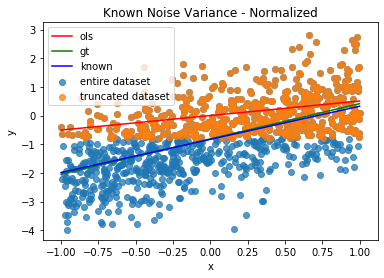

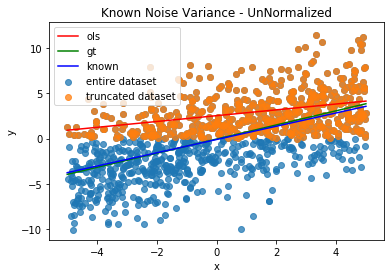

In [35]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_trunc_reg(Tensor(norm_data)).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='r', label='ols')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_weight_unnorm + known_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

Truncated Regression with Unknown Noise Variance

In [46]:
unknown_trunc_reg = TruncatedRegression(phi=emp_scale_phi, alpha=alpha, unknown=True, bs=10, n=100, tol=1e-2, val=100, steps=2000, step_lr_gamma=1.0)
unknown_trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)

unknown_weight_unnorm = (unknown_trunc_reg.weight  * ch.sqrt(emp_noise_var)) / beta
unknown_bias_unnorm = unknown_trunc_reg.intercept * ch.sqrt(emp_noise_var) + trunc_ols.intercept_

Iteration: 0.0 | Score: 0.19935822486877441
Iteration: 1.0 | Score: 0.13923092186450958
Iteration: 2.0 | Score: 0.10559302568435669
Iteration: 3.0 | Score: 0.10563316941261292
Iteration: 4.0 | Score: 0.08363194018602371
Iteration: 5.0 | Score: 0.09220293164253235
Iteration: 6.0 | Score: 0.1387084722518921
Iteration: 7.0 | Score: 0.041503604501485825
Iteration: 8.0 | Score: 0.21274176239967346
Iteration: 9.0 | Score: 0.163943812251091
Iteration: 10.0 | Score: 0.1934526264667511
Iteration: 11.0 | Score: 0.22898326814174652
Iteration: 12.0 | Score: 0.2433662861585617
Iteration: 13.0 | Score: 0.20433394610881805
Iteration: 14.0 | Score: 0.11090316623449326
Iteration: 15.0 | Score: 0.09378673881292343
Iteration: 16.0 | Score: 0.09576207399368286
Iteration: 17.0 | Score: 0.08441003412008286
Iteration: 18.0 | Score: 0.14254021644592285
Iteration: 19.0 | Score: 0.14438937604427338
Iteration: 20.0 | Score: 0.07567647099494934


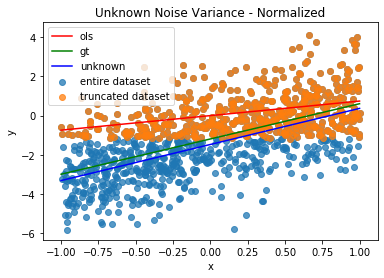

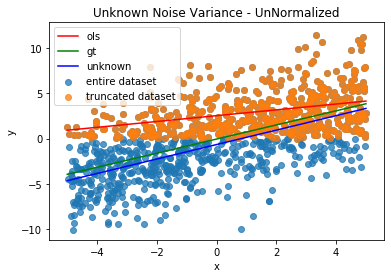

In [47]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, unknown_trunc_reg(Tensor(norm_data)).detach().numpy(), label='unknown', color='blue')
plt.legend()
ax.set_title("Unknown Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), label='ols', color='red')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='g', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@unknown_weight_unnorm + unknown_bias_unnorm), color='blue', label='unknown')
plt.legend()
ax.set_title("Unknown Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

# Truncate at Zero and Run for High Variance

In [4]:
EXP = 'stuff'
# EXP = 'debug'
# EXP = 'DEBUG_5KFuzzyStepLRVar51500Samples10Trials1e-1Val.15'
# EXP = 'NoUpdate5kTol1e-21500Samples__'
# EXP = 'Update5kTol1e-21500Samples_'

In [5]:
def run_trial(kwargs, X, y, tol, attempts):
    """
    Runs a trial of a truncated regression experiment. Runs a maximum 
    of three trials of an experiment. The experiment terminates when either 
    the norm of teh score is less than 3e-1, or when three trials is up. After 
    three trials it returns the best truncated regression experiment.
    :param kwargs: keyword arguments for experiment 
    :param X: independent variable
    :param y: dependent variable
    :return: truncated regression experiment and time that experiment took
    """
    st = datetime.datetime.now()        
    # run procedure until get reasonable score
    attempt, score, best_trunc_reg = 0, None, None
    while (score is None or score.norm() > tol) and attempt < attempts:
        trunc_reg = TruncatedRegression(**kwargs)
        trunc_reg.fit(X, y)
        grad = trunc_reg.score()
        if score is None or grad.norm() < score.norm(): 
            score, best_trunc_reg = grad, trunc_reg
        attempt += 1
    total_time = int((datetime.datetime.now() - st).total_seconds())
    return best_trunc_reg, total_time    

In [6]:
 # expriment parameters
w_lower, w_upper = -1, 1
d, k = 2, 1
# distribution for generating feature vectors
W = Uniform(w_lower, w_upper)
dist = Uniform(-5, 5)
phi = oracle.Left(0.0)

# generate ground truth
gt = ch.nn.Linear(in_features=d, out_features=k)
gt.weight = ch.nn.Parameter(W.sample(ch.Size([k, d])))
gt.bias = ch.nn.Parameter(W.sample(ch.Size([1, 1]))) if args.bias else None

# create base classifier
with ch.no_grad():
    # generate data
    X = dist.sample(ch.Size([args.samples, d])) if isinstance(dist, Uniform) else dist.sample(ch.Size([args.samples]))
    y = gt(X)

In [7]:
for i in range(args.trials):
    # create store and add table
    store = Store(args.out_dir + '/' + EXP)
    store.add_table(TABLE_NAME, { 
        'ols_r2': float,
        'ols_param_mse': float,
        'ols_var_l1': float,
        'known_emp_r2': float,
        'known_emp_param_mse': float,
        'known_emp_time': int,
        'known_r2': float,
        'known_param_mse': float,
        'known_time': int,
        'unknown_r2': float, 
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_time': int,
        'trunc_reg_r2': float,
        'trunc_reg_param_mse': float, 
        'trunc_reg_var_mse': float,
        'trunc_reg_time': int,
        'alpha': float, 
        'num_samples': int,
        'noise_var': float, 
    })
    rand_noise = ch.randn(X.size(0), 1)
        
    for noise_var in range(1, args.var + 1): 
        noise_var = Tensor([noise_var])[None,...]
        # add noise to ground-truth pedictions
        noised = y + ch.sqrt(noise_var)*rand_noise
        # truncate based off of the standardized data
        indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
        y_trunc, x_trunc = noised[indices], X[indices]
        alpha = Tensor([y_trunc.size(0) / args.samples])
        # mean for dependent variable
        y_trunc_mu = y_trunc.mean(0)
        
        # normalize x features so that ||x_{i}||_{2}^{2} <= 1
        l_inf = LA.norm(x_trunc, dim=-1, ord=float('inf')).max() # find max l_inf
        # calculate normalizing constant
        beta = l_inf*math.sqrt(d)
        """
        Divide input features by normalizing constant. By doing so, 
        the weights will be increased by a magnitude of beta.
        """
        x_trunc_norm = x_trunc / beta
         # normalize entire dataset by beta
        x_norm = X / beta
        
        # ground-truth ols
        gt_ols = LinearRegression()
        gt_ols.fit(X, noised)
        gt_params = ch.cat([Tensor(gt_ols.coef_).T, Tensor(gt_ols.intercept_)[..., None]]).flatten()
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        ols_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[..., None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        # check r2 for entire dataset
        ols_pred = ols.predict(X)

        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(noised.flatten(), ols_pred.flatten()), 
            'ols_var_l1': ch.abs(ols_var - noise_var),
            'ols_param_mse': mse_loss(ols_params, gt_params),
        })
        
        val = int(.15*x_trunc.size(0))
        
        """
        Run dataset on truncated regression with known variance, while 
        assuming that the empirical noise variance is the underlying noise 
        variance of our linear regression. This means that we want to standardize 
        our dependent variable by the empirical noise variance. 
        """
        # variance of the residuals
        emp_noise_var = (y_trunc - ols.predict(x_trunc)).var(0)
        # standardize y trunc by the empirical noise variance
        emp_stand_y_trunc = (y_trunc - y_trunc_mu) / ch.sqrt(ols_var)
        # standardize noised by the empirical noise variance
        emp_stand_noised = noised / ch.sqrt(emp_noise_var)
        
        emp_stand_phi = oracle.Left((phi.left - y_trunc_mu) / ch.sqrt(emp_noise_var))
        known_emp_kwargs = { 
            'phi': emp_stand_phi, 
            'alpha': alpha, 
            'unknown': False, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps,
            'lr': args.lr, 
            'step_lr': args.step_lr, 
            'step_lr_gamma': args.step_lr_gamma,
            'eps': args.eps,
            'val': val
        }
        known_emp_trunc_reg, total_time = run_trial(known_emp_kwargs, x_trunc_norm, emp_stand_y_trunc, args.tol, args.attempts)
        w, w0 = (known_emp_trunc_reg.weight * ch.sqrt(emp_noise_var)) / beta, known_emp_trunc_reg.intercept[..., None] * ch.sqrt(emp_noise_var) + y_trunc_mu
        known_emp_params = ch.cat([w, w0]).flatten()

        # known emp results
        store[TABLE_NAME].update_row({
            'known_emp_r2': r2_score(noised.flatten(), X@w + w0), 
            'known_emp_param_mse': mse_loss(known_emp_params, gt_params),
            'known_emp_time': total_time, 
        })

        """
        Run dataset on truncated regression with known variance. This means that we want to standardize 
        our dependent variable by the true noise variance. 
        """
        # standardize y trunc by actual noise variance
        stand_y_trunc = (y_trunc - y_trunc_mu) / ch.sqrt(noise_var)
        # standardize noised by actual noise variance
        stand_noised = noised / ch.sqrt(noise_var)
        stand_phi = oracle.Left((phi.left - y_trunc_mu) / ch.sqrt(noise_var))
    
        # run procedure until get reasonable score
        known_kwargs = { 
            'phi': stand_phi, 
            'alpha': alpha, 
            'unknown': False, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps,
            'lr': args.lr, 
            'step_lr': args.step_lr, 
            'step_lr_gamma': args.step_lr_gamma,
            'eps': args.eps,
            'val': val
        }
        known_trunc_reg, total_time = run_trial(known_kwargs, x_trunc_norm, stand_y_trunc, args.tol, args.attempts)
        w, w0 = (known_trunc_reg.weight * ch.sqrt(noise_var)) / beta, known_trunc_reg.intercept[..., None] * ch.sqrt(noise_var) + y_trunc_mu
        known_params = ch.cat([w, w0]).flatten()
        # known results
        store[TABLE_NAME].update_row({
            'known_r2': r2_score(noised.flatten(), X@w + w0), 
            'known_param_mse': mse_loss(known_params, gt_params),
            'known_time': total_time, 
        })

        
        # truncated regression with unknown variance
        # run procedure until get reasonable score
        unknown_kwargs = { 
            'phi': emp_stand_phi, 
            'alpha': alpha, 
            'unknown': True, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps,
            'lr': args.lr, 
            'var_lr': args.var_lr,
            'step_lr': args.step_lr, 
            'step_lr_gamma': args.step_lr_gamma,
            'eps': args.eps,
            'val': val
        }
        unknown_trunc_reg, total_time = run_trial(unknown_kwargs, x_trunc_norm, emp_stand_y_trunc, args.tol, args.attempts)
        unknown_var = unknown_trunc_reg.variance * emp_noise_var
        w, w0 = (unknown_trunc_reg.weight * ch.sqrt(emp_noise_var)) / beta, unknown_trunc_reg.intercept * ch.sqrt(emp_noise_var) + y_trunc_mu
        unknown_params = ch.cat([w, w0]).flatten()
        # known emp results
        store[TABLE_NAME].update_row({
            'unknown_r2': r2_score(noised.flatten(), X@w + w0), 
            'unknown_param_mse': mse_loss(unknown_params, gt_params),
            'unknown_var_l1': float(ch.abs(unknown_var - noise_var)),
            'unknown_time': total_time, 
        })
            
            
        # spawn subprocess to run truncreg experiment
        concat = ch.cat([x_trunc, y_trunc], dim=1).numpy()
        """
        DATA FORMAT:
            -First n-1 columns are independent variables
            -nth column is dependent variable
        """
        concat_df = pd.DataFrame(concat)
        concat_df.to_csv(args.out_dir + '/' + TMP_FILE) # save data to csv
        """
        Arguments
        - c - truncation point (float)
        - dir - left or right -> type of truncation (str)
        """
        cmd = [COMMAND, PATH2SCRIPT] + [str(0), str(d), 'left', args.out_dir]

        # check_output will run the command and store the result
        st = datetime.datetime.now()
        result = subprocess.check_output(cmd, universal_newlines=True)
        trunc_res = Tensor(pd.read_csv(args.out_dir + '/' + RESULT_FILE)['x'].to_numpy())
        trunc_reg_params = ch.cat([trunc_res[1:-1].flatten(), trunc_res[0][None,...]])

        trunc_reg_pred = X@trunc_reg_params[:-1] + trunc_reg_params[-1]
        
        # truncreg results
        store[TABLE_NAME].update_row({
            'trunc_reg_r2': r2_score(noised.flatten(), trunc_reg_pred.flatten()), 
            'trunc_reg_param_mse': mse_loss(trunc_reg_params, gt_params),
            'trunc_reg_var_mse': ch.abs(trunc_res[-1].pow(2)[None,...] - noise_var),
            'trunc_reg_time': int((datetime.datetime.now() - st).total_seconds()), 
            })
        
        # add additional exp data to store
        store[TABLE_NAME].update_row({ 
            'alpha': float(alpha.flatten()),
            'num_samples': x_trunc.size(0),
            'noise_var': noise_var, 
        })

        # append row to table
        store[TABLE_NAME].flush_row()
    store.close()    

Logging in: /Users/patroklos/Regression/stuff/185491b2-836d-4c31-b1e5-7dc5581dbab0
Iteration 0 | Score: 0.2124136984348297
copying
Iteration 1 | Score: 0.07970493286848068
copying
Iteration 2 | Score: 0.1862640529870987
loading
Iteration 3 | Score: 0.28508323431015015
loading
Iteration 4 | Score: 0.09367333352565765
Iteration 5 | Score: 0.05340943485498428
copying
Iteration 6 | Score: 0.06666319817304611
Iteration 7 | Score: 0.07411087304353714
Iteration 8 | Score: 0.12011078000068665
Iteration 9 | Score: 0.2127240002155304
loading
Iteration 10 | Score: 0.14562654495239258
Iteration 11 | Score: 0.06995067000389099
Iteration 12 | Score: 0.05194832384586334
copying
Iteration 13 | Score: 0.09338469058275223
Iteration 14 | Score: 0.0945306122303009
Iteration 15 | Score: 0.13042432069778442
Iteration 16 | Score: 0.12948742508888245
Iteration 17 | Score: 0.11222434788942337
Iteration 18 | Score: 0.11294344067573547
Iteration 19 | Score: 0.1123199611902237
Iteration 20 | Score: 0.133342221379

Iteration 41 | Score: 0.12185913324356079
Iteration 42 | Score: 0.14938393235206604
Iteration 43 | Score: 0.1348273903131485
Iteration 44 | Score: 0.13493937253952026
Iteration 45 | Score: 0.13886237144470215
Iteration 46 | Score: 0.13658219575881958
Iteration 47 | Score: 0.13412591814994812
Iteration 48 | Score: 0.12215978652238846
Iteration 49 | Score: 0.13186860084533691
Iteration 50 | Score: 0.11685863137245178
Iteration 0 | Score: 0.06927397102117538
copying
Iteration 1 | Score: 0.06341178715229034
copying
Iteration 2 | Score: 0.10970865935087204
Iteration 3 | Score: 0.12078294157981873
Iteration 4 | Score: 0.07131734490394592
Final Score: 0.004509009420871735
Iteration 0 | Score: 0.24273979663848877
copying
Iteration 1 | Score: 0.06794147938489914
copying
Iteration 2 | Score: 0.13540378212928772
Iteration 3 | Score: 0.13500653207302094
Iteration 4 | Score: 0.02926631085574627
copying
Iteration 5 | Score: 0.18961437046527863
loading
Iteration 6 | Score: 0.21026647090911865
loading

Iteration 5 | Score: 0.09890535473823547
Iteration 6 | Score: 0.09575679153203964
Iteration 7 | Score: 0.05668682977557182
Iteration 8 | Score: 0.10395399481058121
Iteration 9 | Score: 0.07373543083667755
Iteration 10 | Score: 0.10800305753946304
Iteration 11 | Score: 0.09094608575105667
Iteration 12 | Score: 0.08718259632587433
Iteration 13 | Score: 0.07355421036481857
Iteration 14 | Score: 0.09878881275653839
Iteration 15 | Score: 0.08831186592578888
Iteration 16 | Score: 0.09055887162685394
Iteration 17 | Score: 0.08882426470518112
Iteration 18 | Score: 0.08325433731079102
Iteration 19 | Score: 0.0733206570148468
Iteration 20 | Score: 0.07976279407739639
Iteration 21 | Score: 0.08966589719057083
Iteration 22 | Score: 0.0912352055311203
Iteration 23 | Score: 0.0809684619307518
Iteration 24 | Score: 0.08634160459041595
Iteration 25 | Score: 0.10175403952598572
Iteration 26 | Score: 0.08554382622241974
Iteration 27 | Score: 0.10468519479036331
Iteration 28 | Score: 0.0854596197605133
I

Iteration 38 | Score: 0.10963919758796692
Iteration 39 | Score: 0.16434912383556366
loading
Iteration 40 | Score: 0.13850249350070953
Iteration 41 | Score: 0.10438366234302521
Iteration 42 | Score: 0.16880005598068237
loading
Iteration 43 | Score: 0.10617619007825851
Iteration 44 | Score: 0.12662628293037415
Iteration 45 | Score: 0.13257744908332825
Iteration 46 | Score: 0.14881452918052673
Iteration 47 | Score: 0.16667845845222473
loading
Iteration 48 | Score: 0.11370745301246643
Iteration 49 | Score: 0.08158806711435318
Iteration 50 | Score: 0.10031351447105408
Iteration 0 | Score: 0.41530799865722656
copying
Iteration 1 | Score: 0.16093626618385315
copying
Iteration 2 | Score: 0.18958508968353271
Iteration 3 | Score: 0.20056259632110596
Iteration 4 | Score: 0.1833966225385666
Iteration 5 | Score: 0.16609397530555725
Iteration 6 | Score: 0.17679765820503235
Iteration 7 | Score: 0.17659185826778412
Iteration 8 | Score: 0.19757600128650665
Iteration 9 | Score: 0.1966630518436432
Iterat

Iteration 41 | Score: 0.030542872846126556
Iteration 42 | Score: 0.038534194231033325
Iteration 43 | Score: 0.03457367792725563
Iteration 44 | Score: 0.03756876289844513
Iteration 45 | Score: 0.034319788217544556
Iteration 46 | Score: 0.02911515161395073
Iteration 47 | Score: 0.02299763262271881
Iteration 48 | Score: 0.04031084105372429
Iteration 49 | Score: 0.03331783786416054
Iteration 50 | Score: 0.03772016614675522
Iteration 0 | Score: 0.288575679063797
copying
Iteration 1 | Score: 0.11800803989171982
copying
Iteration 2 | Score: 0.08038797229528427
copying
Iteration 3 | Score: 0.08329464495182037
Iteration 4 | Score: 0.08384361863136292
Iteration 5 | Score: 0.09798650443553925
Iteration 6 | Score: 0.09608366340398788
Iteration 7 | Score: 0.17732374370098114
Iteration 8 | Score: 0.14284828305244446
Iteration 9 | Score: 0.08333835005760193
Iteration 10 | Score: 0.08520589768886566
Iteration 11 | Score: 0.08311429619789124
Iteration 12 | Score: 0.0679255872964859
copying
Iteration 13

Iteration 25 | Score: 0.0803571343421936
Iteration 26 | Score: 0.10096729546785355
Iteration 27 | Score: 0.08726723492145538
Iteration 28 | Score: 0.08431601524353027
Iteration 29 | Score: 0.08078047633171082
Iteration 30 | Score: 0.07985074818134308
Iteration 31 | Score: 0.08985581994056702
Iteration 32 | Score: 0.08073383569717407
Iteration 33 | Score: 0.08108945190906525
Iteration 34 | Score: 0.09322680532932281
Iteration 35 | Score: 0.10282957553863525
Iteration 36 | Score: 0.09627377986907959
Iteration 37 | Score: 0.09387747198343277
Iteration 38 | Score: 0.08980827778577805
Iteration 39 | Score: 0.08720947802066803
Iteration 40 | Score: 0.08936351537704468
Iteration 41 | Score: 0.09205383062362671
Iteration 42 | Score: 0.08358804881572723
Iteration 43 | Score: 0.08186020702123642
Iteration 44 | Score: 0.07681639492511749
Iteration 45 | Score: 0.09360739588737488
Iteration 46 | Score: 0.07299396395683289
Iteration 47 | Score: 0.10867363214492798
Iteration 48 | Score: 0.08072680979

Iteration 2 | Score: 0.10907919704914093
copying
Iteration 3 | Score: 0.10968894511461258
Iteration 4 | Score: 0.10292328894138336
copying
Iteration 5 | Score: 0.18305067718029022
Iteration 6 | Score: 0.16753944754600525
Iteration 7 | Score: 0.17865227162837982
Iteration 8 | Score: 0.18268804252147675
Iteration 9 | Score: 0.18634939193725586
Iteration 10 | Score: 0.1786268651485443
Iteration 11 | Score: 0.1514468938112259
Iteration 12 | Score: 0.1303023397922516
Iteration 13 | Score: 0.12973487377166748
Iteration 14 | Score: 0.11402229964733124
Iteration 15 | Score: 0.13255003094673157
Iteration 16 | Score: 0.16044314205646515
Iteration 17 | Score: 0.145395889878273
Iteration 18 | Score: 0.15379789471626282
Iteration 19 | Score: 0.13654913008213043
Iteration 20 | Score: 0.158126100897789
Iteration 21 | Score: 0.16131426393985748
Iteration 22 | Score: 0.15372169017791748
Iteration 23 | Score: 0.1345144808292389
Iteration 24 | Score: 0.15847931802272797
Iteration 25 | Score: 0.1336086392

Iteration 20 | Score: 0.036196786910295486
Iteration 21 | Score: 0.08986853063106537
Iteration 22 | Score: 0.06009523570537567
Iteration 23 | Score: 0.06883454322814941
Iteration 24 | Score: 0.028607340529561043
Final Score: 0.006493524648249149
Iteration 0 | Score: 0.13988526165485382
copying
Iteration 1 | Score: 0.16802573204040527
Iteration 2 | Score: 0.17581792175769806
Iteration 3 | Score: 0.24559232592582703
loading
Iteration 4 | Score: 0.1523430198431015
Iteration 5 | Score: 0.20395907759666443
Iteration 6 | Score: 0.18183885514736176
Iteration 7 | Score: 0.20039847493171692
Iteration 8 | Score: 0.18324926495552063
Iteration 9 | Score: 0.16392160952091217
Iteration 10 | Score: 0.13033311069011688
copying
Iteration 11 | Score: 0.1499757617712021
Iteration 12 | Score: 0.18324948847293854
Iteration 13 | Score: 0.19205212593078613
Iteration 14 | Score: 0.12753641605377197
copying
Iteration 15 | Score: 0.18911825120449066
Iteration 16 | Score: 0.16450265049934387
Iteration 17 | Score

Iteration 3 | Score: 0.023674078285694122
copying
Iteration 4 | Score: 0.269551157951355
loading
Iteration 5 | Score: 0.11635982245206833
Iteration 6 | Score: 0.11780048161745071
Iteration 7 | Score: 0.14953304827213287
loading
Iteration 8 | Score: 0.15988104045391083
loading
Iteration 9 | Score: 0.1361718773841858
loading
Iteration 10 | Score: 0.13259775936603546
loading
Iteration 11 | Score: 0.1198773980140686
Iteration 12 | Score: 0.1020597591996193
Iteration 13 | Score: 0.1654180884361267
loading
Iteration 14 | Score: 0.13248616456985474
loading
Iteration 15 | Score: 0.09893228113651276
Iteration 16 | Score: 0.1011541411280632
Iteration 17 | Score: 0.08574508130550385
Iteration 18 | Score: 0.11023442447185516
Iteration 19 | Score: 0.1099589616060257
Iteration 20 | Score: 0.08725864440202713
Iteration 21 | Score: 0.10932353883981705
Iteration 22 | Score: 0.11163411289453506
Iteration 23 | Score: 0.11921587586402893
Iteration 24 | Score: 0.08844557404518127
Iteration 25 | Score: 0.08

Iteration 38 | Score: 0.08142375946044922
Iteration 39 | Score: 0.10280025750398636
Iteration 40 | Score: 0.07986947894096375
Iteration 41 | Score: 0.09350354969501495
Iteration 42 | Score: 0.08993498235940933
Iteration 43 | Score: 0.10181007534265518
Iteration 44 | Score: 0.09959632903337479
Iteration 45 | Score: 0.10655172914266586
Iteration 46 | Score: 0.1128624826669693
loading
Final Score: 0.0033318474888801575
Iteration 0 | Score: 0.09299400448799133
copying
Iteration 1 | Score: 0.0928913801908493
copying
Iteration 2 | Score: 0.028652595356106758
copying
Iteration 3 | Score: 0.0698021873831749
Iteration 4 | Score: 0.05379899591207504
Iteration 5 | Score: 0.0828777477145195
Iteration 6 | Score: 0.05354715883731842
Final Score: 0.008054317906498909
Iteration 0 | Score: 0.08514395356178284
copying
Iteration 1 | Score: 0.05807841569185257
copying
Iteration 2 | Score: 0.09822303801774979
Iteration 3 | Score: 0.04891638085246086
copying
Iteration 4 | Score: 0.013499410822987556
copying

Iteration 16 | Score: 0.02774074114859104
Iteration 17 | Score: 0.0502023883163929
Iteration 18 | Score: 0.0521097257733345
Iteration 19 | Score: 0.04480275139212608
Iteration 20 | Score: 0.022141654044389725
Iteration 21 | Score: 0.0359797328710556
Iteration 22 | Score: 0.03267335891723633
Iteration 23 | Score: 0.04207104817032814
Iteration 24 | Score: 0.05460715293884277
Iteration 25 | Score: 0.040449123829603195
Iteration 26 | Score: 0.03261274844408035
Iteration 27 | Score: 0.041503503918647766
Iteration 28 | Score: 0.04388287663459778
Iteration 29 | Score: 0.028497451916337013
Iteration 30 | Score: 0.03584782034158707
Iteration 31 | Score: 0.03811051696538925
Iteration 32 | Score: 0.05258435383439064
Iteration 33 | Score: 0.05431753769516945
Iteration 34 | Score: 0.029207946732640266
Iteration 35 | Score: 0.045832522213459015
Iteration 36 | Score: 0.0383979007601738
Iteration 37 | Score: 0.04416055604815483
Iteration 38 | Score: 0.05808499455451965
Iteration 39 | Score: 0.03540507

Iteration 1 | Score: 0.041283272206783295
copying
Final Score: 0.001285584643483162
Iteration 0 | Score: 0.41178691387176514
copying
Iteration 1 | Score: 0.2527064383029938
copying
Iteration 2 | Score: 0.1604454517364502
copying
Iteration 3 | Score: 0.2066834568977356
Iteration 4 | Score: 0.15588194131851196
copying
Iteration 5 | Score: 0.19036389887332916
Iteration 6 | Score: 0.2288718968629837
Iteration 7 | Score: 0.1685066521167755
Iteration 8 | Score: 0.16486743092536926
Iteration 9 | Score: 0.13657401502132416
copying
Iteration 10 | Score: 0.18142831325531006
Iteration 11 | Score: 0.18676801025867462
Iteration 12 | Score: 0.1664697229862213
Iteration 13 | Score: 0.13324087858200073
copying
Iteration 14 | Score: 0.12894339859485626
copying
Iteration 15 | Score: 0.18852870166301727
Iteration 16 | Score: 0.18139907717704773
Iteration 17 | Score: 0.17354416847229004
Iteration 18 | Score: 0.1683717668056488
Iteration 19 | Score: 0.1848863810300827
Iteration 20 | Score: 0.18850024044513

Iteration 22 | Score: 0.15187248587608337
Iteration 23 | Score: 0.13955390453338623
Iteration 24 | Score: 0.13205912709236145
Iteration 25 | Score: 0.15065306425094604
Iteration 26 | Score: 0.1607540100812912
loading
Iteration 27 | Score: 0.09459646046161652
Iteration 28 | Score: 0.11960126459598541
Iteration 29 | Score: 0.0997156873345375
Iteration 30 | Score: 0.12827785313129425
Iteration 31 | Score: 0.12486251443624496
Iteration 32 | Score: 0.13639681041240692
Iteration 33 | Score: 0.14185106754302979
Iteration 34 | Score: 0.12649905681610107
Iteration 35 | Score: 0.1280396729707718
Iteration 36 | Score: 0.12545007467269897
Iteration 37 | Score: 0.13671806454658508
Iteration 38 | Score: 0.15246805548667908
Iteration 39 | Score: 0.1210455372929573
Iteration 40 | Score: 0.13231369853019714
Iteration 41 | Score: 0.14881129562854767
Iteration 42 | Score: 0.1413598209619522
Iteration 43 | Score: 0.15393559634685516
Iteration 44 | Score: 0.1566009372472763
Iteration 45 | Score: 0.13223601

Iteration 12 | Score: 0.08924628049135208
Iteration 13 | Score: 0.05673748999834061
copying
Iteration 14 | Score: 0.07977530360221863
Iteration 15 | Score: 0.09726113826036453
Iteration 16 | Score: 0.08027403056621552
Iteration 17 | Score: 0.07639617472887039
Iteration 18 | Score: 0.04503770172595978
copying
Iteration 19 | Score: 0.06916786730289459
Iteration 20 | Score: 0.08644630759954453
Iteration 21 | Score: 0.06738363206386566
Iteration 22 | Score: 0.06975977122783661
Iteration 23 | Score: 0.07440023124217987
Iteration 24 | Score: 0.0675957053899765
Iteration 25 | Score: 0.07657529413700104
Iteration 26 | Score: 0.06879538297653198
Iteration 27 | Score: 0.07143022865056992
Iteration 28 | Score: 0.07177117466926575
Iteration 29 | Score: 0.07244328409433365
Iteration 30 | Score: 0.07187309861183167
Iteration 31 | Score: 0.06936988979578018
Iteration 32 | Score: 0.08460802584886551
Iteration 33 | Score: 0.06522320955991745
Iteration 34 | Score: 0.07509765774011612
Iteration 35 | Scor

Iteration 40 | Score: 0.09864234924316406
Iteration 41 | Score: 0.1031416803598404
Iteration 42 | Score: 0.09294638782739639
Iteration 43 | Score: 0.10133317857980728
Iteration 44 | Score: 0.1089477390050888
Iteration 45 | Score: 0.09146109223365784
Iteration 46 | Score: 0.09758265316486359
Iteration 47 | Score: 0.09979215264320374
Iteration 48 | Score: 0.09300210326910019
Iteration 49 | Score: 0.10395170748233795
Iteration 50 | Score: 0.11751969158649445
Iteration 0 | Score: 0.24875900149345398
copying
Iteration 1 | Score: 0.048819273710250854
copying
Iteration 2 | Score: 0.04409758001565933
copying
Final Score: 0.008622066117823124
Iteration 0 | Score: 0.19161365926265717
copying
Iteration 1 | Score: 0.014776760712265968
copying
Iteration 2 | Score: 0.030522992834448814
Final Score: 0.0014126435853540897
Iteration 0 | Score: 0.3198527693748474
copying
Iteration 1 | Score: 0.02373587340116501
copying
Iteration 2 | Score: 0.15602964162826538
loading
Iteration 3 | Score: 0.2839329838752

Iteration 12 | Score: 0.13877342641353607
Iteration 13 | Score: 0.15094658732414246
Iteration 14 | Score: 0.163473442196846
Iteration 15 | Score: 0.12456770986318588
Iteration 16 | Score: 0.1298937350511551
Iteration 17 | Score: 0.135495126247406
Iteration 18 | Score: 0.1541147232055664
Iteration 19 | Score: 0.14858072996139526
Iteration 20 | Score: 0.1400008201599121
Iteration 21 | Score: 0.13729719817638397
Iteration 22 | Score: 0.145426943898201
Iteration 23 | Score: 0.13802063465118408
Iteration 24 | Score: 0.13355934619903564
Iteration 25 | Score: 0.12927323579788208
Iteration 26 | Score: 0.1509089171886444
Iteration 27 | Score: 0.12315700203180313
Iteration 28 | Score: 0.12567229568958282
Iteration 29 | Score: 0.16939321160316467
Iteration 30 | Score: 0.1580725610256195
Iteration 31 | Score: 0.14617596566677094
Iteration 32 | Score: 0.1195090264081955
Iteration 33 | Score: 0.13348959386348724
Iteration 34 | Score: 0.14530403912067413
Iteration 35 | Score: 0.13680946826934814
Iter

Iteration 49 | Score: 0.15240970253944397
Iteration 50 | Score: 0.1634659618139267
Iteration 0 | Score: 0.051970988512039185
copying
Iteration 1 | Score: 0.13053905963897705
Iteration 2 | Score: 0.11189693212509155
Iteration 3 | Score: 0.07421352714300156
Iteration 4 | Score: 0.15511758625507355
loading
Iteration 5 | Score: 0.24563589692115784
loading
Iteration 6 | Score: 0.1664174497127533
loading
Iteration 7 | Score: 0.1437062919139862
Iteration 8 | Score: 0.17403993010520935
loading
Iteration 9 | Score: 0.16876420378684998
loading
Iteration 10 | Score: 0.1826726645231247
loading
Iteration 11 | Score: 0.1723298728466034
loading
Iteration 12 | Score: 0.1551048308610916
loading
Iteration 13 | Score: 0.14791688323020935
Iteration 14 | Score: 0.1325947493314743
Iteration 15 | Score: 0.16585209965705872
loading
Iteration 16 | Score: 0.18546311557292938
loading
Iteration 17 | Score: 0.1406632363796234
Iteration 18 | Score: 0.14747056365013123
Iteration 19 | Score: 0.161411851644516
loading

Iteration 27 | Score: 0.13390697538852692
Iteration 28 | Score: 0.09677798300981522
Iteration 29 | Score: 0.14974693953990936
loading
Iteration 30 | Score: 0.10117565095424652
Iteration 31 | Score: 0.16434122622013092
loading
Iteration 32 | Score: 0.09188532829284668
Iteration 33 | Score: 0.11945021897554398
Iteration 34 | Score: 0.10078354924917221
Iteration 35 | Score: 0.10133316367864609
Iteration 36 | Score: 0.13298916816711426
Iteration 37 | Score: 0.1653846651315689
loading
Iteration 38 | Score: 0.13561031222343445
Iteration 39 | Score: 0.0978902280330658
Iteration 40 | Score: 0.1250923126935959
Iteration 41 | Score: 0.1643473207950592
loading
Iteration 42 | Score: 0.08406827598810196
Iteration 43 | Score: 0.11802984774112701
Iteration 44 | Score: 0.10833439975976944
Iteration 45 | Score: 0.13397768139839172
Iteration 46 | Score: 0.17116114497184753
loading
Iteration 47 | Score: 0.08917828649282455
Iteration 48 | Score: 0.05884064361453056
Iteration 49 | Score: 0.0963700115680694

Iteration 1 | Score: 0.17664963006973267
copying
Iteration 2 | Score: 0.01898944191634655
copying
Iteration 3 | Score: 0.22215528786182404
loading
Iteration 4 | Score: 0.126416876912117
loading
Iteration 5 | Score: 0.1528434157371521
loading
Iteration 6 | Score: 0.15867246687412262
loading
Iteration 7 | Score: 0.1459394246339798
loading
Iteration 8 | Score: 0.20875300467014313
loading
Iteration 9 | Score: 0.16758516430854797
loading
Iteration 10 | Score: 0.12072781473398209
loading
Iteration 11 | Score: 0.17768129706382751
loading
Iteration 12 | Score: 0.0738714411854744
Iteration 13 | Score: 0.09529828280210495
Iteration 14 | Score: 0.12364660203456879
loading
Iteration 15 | Score: 0.10073669254779816
Iteration 16 | Score: 0.11829023063182831
Iteration 17 | Score: 0.12151355296373367
loading
Iteration 18 | Score: 0.07818987220525742
Iteration 19 | Score: 0.10853094607591629
Iteration 20 | Score: 0.09870177507400513
Iteration 21 | Score: 0.09592907875776291
Iteration 22 | Score: 0.1159

Iteration 31 | Score: 0.10593912750482559
Iteration 32 | Score: 0.10867579281330109
Iteration 33 | Score: 0.12052799016237259
Iteration 34 | Score: 0.11104270815849304
Iteration 35 | Score: 0.10280890017747879
Iteration 36 | Score: 0.08283069729804993
Iteration 37 | Score: 0.10077188163995743
Iteration 38 | Score: 0.11985749751329422
Iteration 39 | Score: 0.11329004168510437
Iteration 40 | Score: 0.10198083519935608
Iteration 41 | Score: 0.11279206722974777
Iteration 42 | Score: 0.10904441773891449
Iteration 43 | Score: 0.13302259147167206
Iteration 44 | Score: 0.09417479485273361
Iteration 45 | Score: 0.10414322465658188
Iteration 46 | Score: 0.12224797159433365
Iteration 47 | Score: 0.12431760132312775
Iteration 48 | Score: 0.1115325391292572
Iteration 49 | Score: 0.11152353882789612
Iteration 50 | Score: 0.1069970652461052
Iteration 0 | Score: 0.3155103921890259
copying
Iteration 1 | Score: 0.2510926425457001
copying
Iteration 2 | Score: 0.1143423467874527
copying
Iteration 3 | Scor

Iteration 14 | Score: 0.10823369026184082
Iteration 15 | Score: 0.14302420616149902
loading
Iteration 16 | Score: 0.07084324955940247
Iteration 17 | Score: 0.08658665418624878
Iteration 18 | Score: 0.11064036190509796
Iteration 19 | Score: 0.10107474774122238
Iteration 20 | Score: 0.11283386498689651
Iteration 21 | Score: 0.08092296123504639
Iteration 22 | Score: 0.10168936848640442
Iteration 23 | Score: 0.11312363296747208
Iteration 24 | Score: 0.12059421837329865
Iteration 25 | Score: 0.10263742506504059
Iteration 26 | Score: 0.10575718432664871
Iteration 27 | Score: 0.11293524503707886
Iteration 28 | Score: 0.10917213559150696
Iteration 29 | Score: 0.12749098241329193
Iteration 30 | Score: 0.10966937243938446
Iteration 31 | Score: 0.11643099039793015
Iteration 32 | Score: 0.13287106156349182
loading
Final Score: 0.005034901201725006
Iteration 0 | Score: 0.10364006459712982
copying
Iteration 1 | Score: 0.13529597222805023
Iteration 2 | Score: 0.0525301992893219
copying
Iteration 3 | 

Iteration 8 | Score: 0.31706666946411133
loading
Iteration 9 | Score: 0.3411403000354767
loading
Iteration 10 | Score: 0.29084479808807373
loading
Iteration 11 | Score: 0.272916316986084
loading
Iteration 12 | Score: 0.18595632910728455
loading
Iteration 13 | Score: 0.22537074983119965
loading
Iteration 14 | Score: 0.3134927451610565
loading
Iteration 15 | Score: 0.32690510153770447
loading
Iteration 16 | Score: 0.3274901807308197
loading
Iteration 17 | Score: 0.27894455194473267
loading
Iteration 18 | Score: 0.2826235890388489
loading
Iteration 19 | Score: 0.24124349653720856
loading
Iteration 20 | Score: 0.2354736626148224
loading
Iteration 21 | Score: 0.22157205641269684
loading
Iteration 22 | Score: 0.2521670460700989
loading
Iteration 23 | Score: 0.25696128606796265
loading
Iteration 24 | Score: 0.2733682096004486
loading
Iteration 25 | Score: 0.244941845536232
loading
Iteration 26 | Score: 0.2470235526561737
loading
Iteration 27 | Score: 0.23609796166419983
loading
Iteration 28 |

Iteration 26 | Score: 0.058744754642248154
Iteration 27 | Score: 0.04812665283679962
Iteration 28 | Score: 0.06578286737203598
Iteration 29 | Score: 0.04145073518157005
Iteration 30 | Score: 0.07235908508300781
Iteration 31 | Score: 0.0640876442193985
Iteration 32 | Score: 0.08106574416160583
Iteration 33 | Score: 0.06587108224630356
Iteration 34 | Score: 0.058052197098731995
Iteration 35 | Score: 0.07651382684707642
Iteration 36 | Score: 0.0481470450758934
Iteration 37 | Score: 0.06226483732461929
Iteration 38 | Score: 0.06643602252006531
Iteration 39 | Score: 0.07171312719583511
Iteration 40 | Score: 0.05247587710618973
Iteration 41 | Score: 0.061029043048620224
Iteration 42 | Score: 0.06717080622911453
Iteration 43 | Score: 0.044073205441236496
Iteration 44 | Score: 0.07479791343212128
Iteration 45 | Score: 0.058531563729047775
Iteration 46 | Score: 0.07874388247728348
Iteration 47 | Score: 0.058973975479602814
Iteration 48 | Score: 0.06186223030090332
Iteration 49 | Score: 0.068880

In [8]:
reader = CollectionReader(args.out_dir + '/' + EXP)
logs = reader.df(TABLE_NAME)
reader.close()
logs.head(10)

100%|██████████| 35/35 [00:01<00:00, 26.02it/s]
/usr/local/lib/python3.7/site-packages/cox/readers.py:160: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  catted = pd.concat(tables)


new schema missing keys: {'c'}, new keys: {'known_emp_param_mse', 'known_emp_r2', 'known_emp_time'}
new schema missing keys: {'c'}, new keys: {'known_emp_param_mse', 'known_emp_r2', 'known_emp_time'}
new schema missing keys: {'c'}, new keys: {'known_emp_param_mse', 'known_emp_r2', 'known_emp_time'}


,alpha,c,exp_id,known_emp_param_mse,known_emp_r2,known_emp_time,known_param_mse,known_r2,known_time,noise_var,...,ols_r2,ols_var_l1,trunc_reg_param_mse,trunc_reg_r2,trunc_reg_time,trunc_reg_var_mse,unknown_param_mse,unknown_r2,unknown_time,unknown_var_l1
0,0.692000,-2.50,23a54a4d-f7bd-4e98-84f2-32e1694cb677,NaN,NaN,NaN,0.004741,0.779321,1,5.0,...,0.727291,0.865193,0.002813,0.779850,0,0.048342,0.005868,0.778900,5,0.034581
1,0.654000,-2.00,23a54a4d-f7bd-4e98-84f2-32e1694cb677,NaN,NaN,NaN,0.006183,0.777598,1,5.0,...,0.708424,0.901412,0.006904,0.778123,0,0.035151,0.008967,0.775932,0,0.273444
2,0.638000,-1.75,23a54a4d-f7bd-4e98-84f2-32e1694cb677,NaN,NaN,NaN,0.018960,0.767501,0,5.0,...,0.697292,0.963324,0.008330,0.777608,0,0.074122,0.007147,0.775828,2,0.195171
3,0.618667,-1.50,23a54a4d-f7bd-4e98-84f2-32e1694cb677,NaN,NaN,NaN,0.020963,0.772431,0,5.0,...,0.685967,0.963155,0.010375,0.776563,0,0.024953,0.002717,0.778195,16,0.225759
4,0.602000,-1.25,23a54a4d-f7bd-4e98-84f2-32e1694cb677,NaN,NaN,NaN,0.016710,0.774455,2,5.0,...,0.674946,1.008692,0.011073,0.776296,0,0.032509,0.014347,0.774774,2,0.017655
5,0.590000,-1.00,23a54a4d-f7bd-4e98-84f2-32e1694cb677,NaN,NaN,NaN,0.012155,0.775750,1,5.0,...,0.667023,1.043825,0.005794,0.778328,0,0.012854,0.004082,0.777485,5,0.150233
6,0.576667,-0.75,23a54a4d-f7bd-4e98-84f2-32e1694cb677,NaN,NaN,NaN,0.006261,0.777729,1,5.0,...,0.657514,1.050948,0.001836,0.779963,0,0.111799,0.000996,0.779919,2,0.061129
7,0.556000,-0.50,23a54a4d-f7bd-4e98-84f2-32e1694cb677,NaN,NaN,NaN,0.015714,0.774149,1,5.0,...,0.644830,1.104758,0.002605,0.779344,0,0.079583,0.006958,0.778240,4,0.028248
8,0.539333,-0.25,23a54a4d-f7bd-4e98-84f2-32e1694cb677,NaN,NaN,NaN,0.089704,0.739835,0,5.0,...,0.633170,1.200199,0.002026,0.779419,0,0.019727,0.009368,0.778130,2,0.201337
9,0.519333,0.00,23a54a4d-f7bd-4e98-84f2-32e1694cb677,NaN,NaN,NaN,0.009450,0.774419,1,5.0,...,0.613429,1.160087,0.001347,0.779768,0,0.159334,0.000214,0.780542,2,0.028244


In [54]:
cols = ['unknown_param_mse', 'unknown_var_l1', 'noise_var', 'alpha']
unknown_logs = pd.DataFrame(columns=cols)
for var in range(1, args.var + 1): 
    temp = logs[logs['noise_var'] == var][cols].reset_index()
    temp.drop(index=temp[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['unknown_param_mse', 'unknown_var_l1']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    unknown_logs = pd.concat([unknown_logs, temp])
    
unknown_logs = unknown_logs.reset_index()

In [55]:
cols = ['known_param_mse', 'noise_var', 'alpha']
known_logs = pd.DataFrame(columns=cols)
for var in range(1, args.var + 1): 
    temp = logs[logs['noise_var'] == var][cols].reset_index()
    temp.drop(index=temp[['known_param_mse']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['known_param_mse']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    known_logs = pd.concat([known_logs, temp])
known_logs = known_logs.reset_index()

In [56]:
cols = ['known_emp_param_mse', 'noise_var', 'alpha']
known_emp_logs = pd.DataFrame(columns=cols)
for var in range(1, args.var + 1): 
    temp = logs[logs['noise_var'] == var][cols].reset_index()
    temp.drop(index=temp[['known_emp_param_mse']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['known_emp_param_mse']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    known_emp_logs = pd.concat([known_emp_logs, temp])
known_emp_logs = known_emp_logs.reset_index()

In [57]:
cols = ['ols_param_mse', 'ols_var_l1', 'noise_var', 'alpha']
ols_logs = pd.DataFrame(columns=cols)
for var in range(1, args.var + 1): 
    temp = logs[logs['noise_var'] == var][cols].reset_index()
    temp.drop(index=temp[['ols_param_mse', 'ols_var_l1']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['ols_param_mse', 'ols_var_l1']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    ols_logs = pd.concat([ols_logs, temp])
ols_logs = ols_logs.reset_index()

In [58]:
cols = ['trunc_reg_param_mse', 'trunc_reg_var_mse', 'noise_var', 'alpha']
truncreg_logs = pd.DataFrame(columns=cols)
for var in range(1, args.var + 1): 
    temp = logs[logs['noise_var'] == var][cols].reset_index()
    temp.drop(index=temp[['trunc_reg_param_mse', 'trunc_reg_var_mse']].sum(1).idxmax(), inplace=True)
    temp.drop(index=temp[['trunc_reg_param_mse', 'trunc_reg_var_mse']].sum(1).idxmin(), inplace=True)
    temp.drop(['index'], axis=1, inplace=True)
    truncreg_logs = pd.concat([truncreg_logs, temp])
truncreg_logs = truncreg_logs.reset_index()

In [59]:
unknown_logs['unknown_epsilon'] = unknown_logs['unknown_param_mse'] + unknown_logs['unknown_var_l1']
truncreg_logs['trunc_reg_epsilon'] = truncreg_logs['trunc_reg_param_mse'] + truncreg_logs['trunc_reg_var_mse']
ols_logs['ols_epsilon'] = ols_logs['ols_param_mse'] + ols_logs['ols_var_l1']

In [60]:
unknown_logs['unknown_param_mse'] = unknown_logs['unknown_param_mse'] **(1/2)
known_logs['known_param_mse'] = known_logs['known_param_mse'] **(1/2)
ols_logs['ols_param_mse'] = ols_logs['ols_param_mse'] **(1/2)
known_emp_logs['known_emp_param_mse'] = known_emp_logs['known_emp_param_mse'] **(1/2)
truncreg_logs['trunc_reg_param_mse'] = truncreg_logs['trunc_reg_param_mse'] **(1/2)

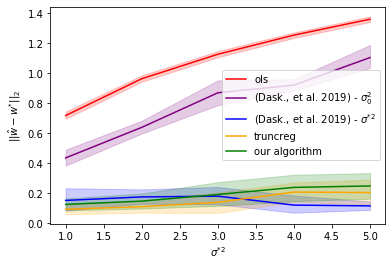

[Text(0, 0.5, '$|\\hat \\sigma^{2} - \\sigma^{*2}|$'),
 Text(0.5, 0, '$\\sigma^{*2}$')]

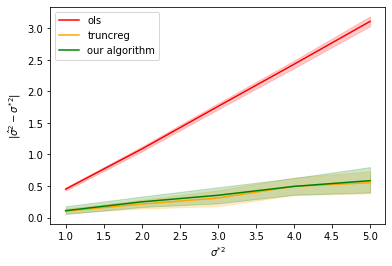

In [61]:
sns.lineplot(data=ols_logs, x='noise_var', y='ols_param_mse', label='ols', color='r')
sns.lineplot(data=known_emp_logs, x='noise_var', y='known_emp_param_mse', color='purple', label='(Dask., et al. 2019) - $\sigma_{0}^{2}$')
sns.lineplot(data=known_logs, x='noise_var', y='known_param_mse', label='(Dask., et al. 2019) - $\sigma^{*2}$', color='blue')
sns.lineplot(data=truncreg_logs, x='noise_var', y='trunc_reg_param_mse', label='truncreg', color='orange')
ax = sns.lineplot(data=unknown_logs, x='noise_var', y='unknown_param_mse', label='our algorithm', color='green')

ax.set(xlabel='$\sigma^{*2}$', ylabel='$||\hat w - w^{*}||_{2}$')
plt.show()

sns.lineplot(data=ols_logs, x='noise_var', y='ols_var_l1', label='ols', color='red')
sns.lineplot(data=truncreg_logs, x='noise_var', y='trunc_reg_var_mse', label='truncreg', color='orange')
ax = sns.lineplot(data=unknown_logs, x='noise_var', y='unknown_var_l1', label='our algorithm', color='green')
ax.set(xlabel='$\sigma^{*2}$', ylabel='$|\hat \sigma^{2} - \sigma^{*2}|$')

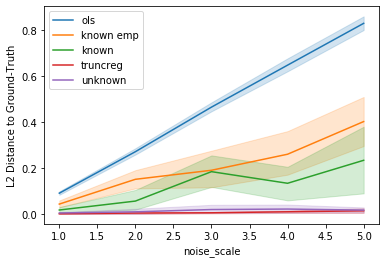

[Text(0, 0.5, 'L1 Distance to Ground-Truth'), Text(0.5, 0, 'noise_scale')]

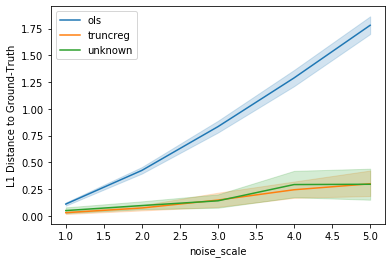

In [34]:
sns.lineplot(data=logs, x='noise_var', y='ols_param_mse', label='ols')
sns.lineplot(data=logs, x='noise_var', y='known_emp_param_mse', label='known emp')
sns.lineplot(data=logs, x='noise_var', y='known_param_mse', label='known')
sns.lineplot(data=logs, x='noise_var', y='trunc_reg_param_mse', label='truncreg')
ax = sns.lineplot(data=logs, x='noise_var', y='unknown_param_mse', label='unknown')
ax.set(xlabel='noise_scale', ylabel='L2 Distance to Ground-Truth')
plt.show()

sns.lineplot(data=logs, x='noise_var', y='ols_var_l1', label='ols')
sns.lineplot(data=logs, x='noise_var', y='trunc_reg_var_mse', label='truncreg')
ax = sns.lineplot(data=logs, x='noise_var', y='unknown_var_l1', label='unknown')
ax.set(xlabel='noise_scale', ylabel='L1 Distance to Ground-Truth')

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
# data = ch.from_numpy(np.linspace(-3.0, 3.0, 100)).unsqueeze(1).float()

ax.scatter3D(X[indices][:,0], X[indices][:,1], noised[indices], color="green", alpha=.1)
ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color="red", alpha=.75)

ax.view_init(10, -150)

In [ ]:
cleaned_logs = pd.DataFrame(columns=logs.columns)
for var in range(1, 21):
    noise_scale = logs[logs['noise_scale'] == var].reset_index()
    noise_scale.drop(index=noise_scale[['unknown_param_mse', 'unknown_var_mse']].sum(1).idxmax(), inplace=True)
    cleaned_logs = pd.concat([cleaned_logs, noise_scale])
cleaned_logs = cleaned_logs.reset_index()